In [1]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import soundfile as sf  # soundfile is a library for reading and writing audio files

In [2]:
import os
import random

def rfd(directory):
    """
    Selects a file or directory at random from the given directory.
    
    Parameters:
        directory (str): Path to the directory containing files and/or directories.
    
    Returns:
        str: Path to the randomly selected file or directory.
    """
    entries = [e for e in os.listdir(directory) if os.path.exists(os.path.join(directory, e))]
    if not entries:
        raise ValueError("No files or directories found in the directory.")
    
    return os.path.join(directory, random.choice(entries))

# Example usage:
directory_path = "wav48/1/"
random_file = rfd(directory_path)
print("Randomly selected file:", random_file)


Randomly selected file: wav48/1/p261


In [3]:
rfd(rfd("wav48/1/"))

'wav48/1/p230/p230_359.wav'

In [1]:
import torch

torch.set_default_dtype(torch.float16)


In [1]:
import torch

In [2]:
import torch.nn as nn

from modules import (
    SEANetEncoder, 
    SEANetDecoder, 
    SEANetResnetBlock,
    SConv1d, 
    SConvTranspose1d, 
    SLSTM
)

In [3]:
class SimpleAutoencoder(nn.Module):
    def __init__(self, channels=1, dimension=128, n_filters=32, n_residual_layers=1,
                 ratios=[8, 5, 4, 2], activation='ELU', norm='weight_norm'):
        super().__init__()
        self.encoder = SEANetEncoder(
            channels=channels,
            dimension=dimension,
            n_filters=n_filters,
            n_residual_layers=n_residual_layers,
            ratios=ratios,
            activation=activation,
            norm=norm
        )
        self.decoder = SEANetDecoder(
            channels=channels,
            dimension=dimension,
            n_filters=n_filters,
            n_residual_layers=n_residual_layers,
            ratios=ratios,
            activation=activation,
            norm=norm
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [4]:
model = SimpleAutoencoder(channels=1, dimension=128, n_filters=32, n_residual_layers=1)

/home/archisman/.local/lib/python3.8/site-packages/torch/nn/utils/weight_norm.py:30: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")


In [4]:
import torch
import torch.nn as nn
from modules import (
    SEANetEncoder, 
    SEANetDecoder, 
    SEANetResnetBlock,
    SConv1d, 
    SConvTranspose1d, 
    SLSTM
)
# from quantization.core_vq import ResidualVectorQuantizer, QuantizedResult
from quantization import (
    QuantizedResult, 
    ResidualVectorQuantizer
)

class SimpleAutoencoder(nn.Module):
    def __init__(self, channels=1, dimension=128, n_filters=32, n_residual_layers=1,
                 ratios=[8, 5, 4, 2], activation='ELU', norm='weight_norm',
                 vq_dimension=128, n_q=8, bins=1024, decay=0.99, kmeans_init=True, 
                 kmeans_iters=50, threshold_ema_dead_code=2):
        super().__init__()
        self.encoder = SEANetEncoder(
            channels=channels,
            dimension=dimension,
            n_filters=n_filters,
            n_residual_layers=n_residual_layers,
            ratios=ratios,
            activation=activation,
            norm=norm
        )
        self.decoder = SEANetDecoder(
            channels=channels,
            dimension=dimension,
            n_filters=n_filters,
            n_residual_layers=n_residual_layers,
            ratios=ratios,
            activation=activation,
            norm=norm
        )
        self.vq = ResidualVectorQuantizer(
            dimension=vq_dimension,
            n_q=n_q,
            bins=bins,
            decay=decay,
            kmeans_init=kmeans_init,
            kmeans_iters=kmeans_iters,
            threshold_ema_dead_code=threshold_ema_dead_code
        )

    def forward(self, x):
        encoded = self.encoder(x)
        quantized_result = self.vq(encoded, frame_rate=75)  # frame_rate can be adjusted as per your data
        quantized = quantized_result.quantized
        decoded = self.decoder(quantized)
        return decoded, quantized_result

# Example instantiation
model = SimpleAutoencoder(channels=1, dimension=128, n_filters=32, n_residual_layers=1)


/home/archisman/.local/lib/python3.8/site-packages/torch/nn/utils/weight_norm.py:30: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")


In [18]:
model.eval();

In [10]:
mdl=model.cpu();

In [2]:
import time

In [9]:
st = time.time()
model(torch.randn(1,1,24000))
et = time.time()
print(et-st)

0.053342342376708984


In [27]:
st = time.time()
model.train()
model.vq(model.encoder(torch.randn(1,1,24000)),24000)
et = time.time()
print(et-st)

0.037255048751831055


In [7]:
#import torch
import torchaudio

class WavDataset(torch.utils.data.Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.file_paths = []
        for dirpath, _, filenames in os.walk(root_dir):
            for filename in filenames:
                if filename.endswith('.wav'):
                    self.file_paths.append(os.path.join(dirpath, filename))
        self.transform = transform
        self.sample_rate = 48000  # Assuming all files have a sample rate of 48000 Hz

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        file_path = self.file_paths[idx]
        waveform, _ = torchaudio.load(file_path)
        
        # Convert to mono if stereo
        if waveform.shape[0] > 1:
            waveform = torch.mean(waveform, dim=0, keepdim=True)
        
        # Sample 1 second from the waveform
        waveform = self.sample_one_second(waveform)
        
        # Apply any necessary preprocessing or transformation
        if self.transform:
            waveform = self.transform(waveform)
        
        return waveform

    def sample_one_second(self, waveform):
        num_samples = waveform.shape[-1]
        if num_samples >= self.sample_rate:
            start_idx = torch.randint(0, num_samples - self.sample_rate, (1,))
            waveform = waveform[:, start_idx:start_idx + self.sample_rate]
        else:
            # If the waveform is shorter than 1 second, pad with zeros
            pad_len = self.sample_rate - num_samples
            waveform = torch.nn.functional.pad(waveform, (0, pad_len))
        return waveform

In [8]:
train_dataset = WavDataset("train1")

In [9]:
val_dataset = WavDataset("val1")

In [10]:
test_dataset = WavDataset("test1")

In [11]:
from torch.utils.data import DataLoader

In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import librosa.filters

class Audio2Mel(nn.Module):
    def __init__(
        self,
        n_fft=1024,
        hop_length=256,
        win_length=1024,
        sampling_rate=22050,
        n_mel_channels=80,
        mel_fmin=0.0,
        mel_fmax=None,
        device='cuda:1'  # Default device is set to 'cuda:0'
    ):
        super().__init__()
        self.device = device  # Store the device to ensure consistency
        self.win_length = win_length
        self.hop_length = hop_length
        self.n_fft = n_fft
        self.window = torch.hann_window(win_length, device=self.device).float()

        # Create the mel filterbank
        mel_basis = librosa.filters.mel(
            sr=sampling_rate,
            n_fft=n_fft,
            n_mels=n_mel_channels,
            fmin=mel_fmin,
            fmax=mel_fmax
        )
        self.mel_basis = torch.from_numpy(mel_basis).to(self.device).float()

    def forward(self, audio):
        # Ensure input is on the correct device
        audio = audio.to(self.device)

        # Padding
        p = (self.n_fft - self.hop_length) // 2
        audio_padded = F.pad(audio, (p, p), "reflect").squeeze(1)

        # Compute the short-time Fourier transform (STFT)
        fft = torch.stft(
            audio_padded,
            n_fft=self.n_fft,
            hop_length=self.hop_length,
            win_length=self.win_length,
            window=self.window,
            center=False,
            return_complex=True
        )

        # Power spectrum
        power = torch.abs(fft)**2

        # Apply mel filterbank
        mel_output = torch.matmul(self.mel_basis, power)
        
        # Log scale
        log_mel_spec = torch.log10(torch.clamp(mel_output, min=1e-5))
        
        return log_mel_spec


In [19]:
import torch
#from audio_to_mel import Audio2Mel

def total_loss(wav1, wav2, sample_rate=48000):
    l1Loss = torch.nn.L1Loss(reduction='mean')
    l2Loss = torch.nn.MSELoss(reduction='mean')
    loss = torch.tensor(0.0, device=wav1.device, requires_grad=True)
    l1_mel_loss_total = torch.tensor(0.0, device=wav1.device)
    l2_mel_loss_total = torch.tensor(0.0, device=wav1.device)

    # Assuming one mel transformation for simplicity
    fft = Audio2Mel(win_length=256, hop_length=64, n_mel_channels=64, sampling_rate=sample_rate)
    mel1 = fft(wav1)
    mel2 = fft(wav2)
    l1_mel_loss = l1Loss(mel1, mel2)
    l2_mel_loss = l2Loss(mel1, mel2)
    loss = loss + l1_mel_loss + l2_mel_loss

    # L1 loss for the raw audio
    l1_raw_loss = l1Loss(wav1, wav2)
    loss = loss + l1_raw_loss

    return loss, l1_mel_loss, l2_mel_loss, l1_raw_loss


In [12]:
import torch
#from audio_to_mel import Audio2Mel


def total_loss(wav1, wav2, sample_rate=48000):
    l1Loss = torch.nn.L1Loss(reduction='mean')
    l2Loss = torch.nn.MSELoss(reduction='mean')
    # Initialize loss as a zero tensor with gradient tracking
    loss = torch.tensor(0.0, device=wav1.device, requires_grad=True)
    l1mel = torch.tensor(0.0, device=wav1.device, requires_grad=True)
    l2mel = torch.tensor(0.0, device=wav1.device, requires_grad=True)
    l1raw = torch.tensor(0.0, device=wav1.device, requires_grad=True)
    
    n=0

    # Loop over a set of parameters for mel transformation
    for i in range(8, 9):
        fft = Audio2Mel(win_length=2 ** i, hop_length=2 ** i // 4, n_mel_channels=64, sampling_rate=sample_rate)
        mel1 = fft(wav1)
        mel2 = fft(wav2)
        l1mel = l1Loss(mel1, mel2)
        l2mel = l2Loss(mel1, mel2)
        # Add L1 and L2 loss for the mel spectrograms
        loss = loss + l1mel + l2mel
        n+=1

    # Average the loss over the number of mel spectrogram comparisons
    loss = loss/n

    # Add L1 loss for the raw audio
    l1raw = l1Loss(wav1, wav2)
    loss = loss + l1raw

    return loss,l1raw,l1mel,l2mel


In [5]:
import torchaudio

In [11]:
torchaudio.load(rfd("train"))[0].to(torch.float16).dtype

torch.float16

# Train Script

In [12]:
import torch
#from audio_to_mel import Audio2Mel


def total_loss(wav1, wav2, sample_rate=48000):
    l1Loss = torch.nn.L1Loss(reduction='mean')
    l2Loss = torch.nn.MSELoss(reduction='mean')
    # Initialize loss as a zero tensor with gradient tracking
    loss = torch.tensor(0.0, device=wav1.device, requires_grad=True)

    # Loop over a set of parameters for mel transformation
    for i in range(8, 9):
        fft = Audio2Mel(win_length=2 ** i, hop_length=2 ** i // 4, n_mel_channels=64, sampling_rate=sample_rate)
        mel1 = fft(wav1)
        mel2 = fft(wav2)
        # Add L1 and L2 loss for the mel spectrograms
        loss = loss + l1Loss(mel1, mel2) + l2Loss(mel1, mel2)

    # Average the loss over the number of mel spectrogram comparisons
    loss = loss 

    # Add L1 loss for the raw audio
    loss = loss + l1Loss(wav1, wav2)

    return loss


In [6]:
ddr = "/home/archisman/SSDdir/AB_datasets/Encodec/"

In [6]:
import os
import torch
import torchaudio
import numpy as np
import random

# Set seeds for reproducibility
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Set the seed
seed = 42
set_seed(seed)

class WavDataset(torch.utils.data.Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.file_paths = []
        for dirpath, _, filenames in os.walk(root_dir):
            for filename in filenames:
                if filename.endswith('.wav'):
                    self.file_paths.append(os.path.join(dirpath, filename))
        self.transform = transform
        self.sample_rate = 24000  # Assuming all files have a sample rate of 48000 Hz

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        file_path = self.file_paths[idx]
        waveform, _ = torchaudio.load(file_path)
        
        # Convert to mono if stereo
        if waveform.shape[0] > 1:
            waveform = torch.mean(waveform, dim=0, keepdim=True)
        
        # Apply any necessary preprocessing or transformation
        if self.transform:
            waveform = self.transform(waveform)
        
        return waveform

train_dataset = WavDataset(ddr+"train24khz")
val_dataset = WavDataset(ddr+"val24khz")
test_dataset = WavDataset(ddr+"test24khz")

import torch.nn as nn
from torch.utils.data import DataLoader

# Assuming a model and loss function are defined elsewhere
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

sample_rate = 24000
loss_fn = nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)

train_losses = []
val_losses = []
test_losses = []

num_epochs = 10
t_half = 2  # Evaluate and potentially change the learning rate every 50 epochs

batch_size = 64
num_workers = 4  # Number of CPU workers

# Ensure the worker seed is set for dataloader workers to maintain reproducibility in shuffling
def worker_init_fn(worker_id):
    np.random.seed(seed + worker_id)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=num_workers, worker_init_fn=worker_init_fn)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=num_workers)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=num_workers)

learning_rates = [0.0005, 0.0001, 0.00005, 0.00001, 0.000005]
current_lr_index = 0

for epoch in range(num_epochs):
    model.train()
    epoch_train_loss = 0.0
    for batch in train_dataloader:
        waveforms = batch.to(device)
        decoded_output, quantized_result = model(waveforms)  # Unpack the tuple
        loss = loss_fn(decoded_output, waveforms)  # Use only the decoded_output for loss calculation
        epoch_train_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Free output and loss from GPU memory
        del output, loss
        torch.cuda.empty_cache()  # Use cautiously

    epoch_train_loss /= len(train_dataloader)
    train_losses.append(epoch_train_loss)

    model.eval()
    epoch_val_loss = 0.0
    with torch.no_grad():
        for batch in val_dataloader:
            waveforms = batch.to(device)
            output = model(waveforms)
            loss = loss_fn(output, waveforms)
            epoch_val_loss += loss.item()

            # Free output and loss from GPU memory
            del output, loss

    epoch_val_loss /= len(val_dataloader)
    val_losses.append(epoch_val_loss)
    torch.cuda.empty_cache()  # Clear cache after validation

    if (epoch + 1) % t_half == 0:
        epoch_test_loss = 0.0
        with torch.no_grad():
            for batch in test_dataloader:
                waveforms = batch.to(device)
                output = model(waveforms)
                loss = loss_fn(output, waveforms)
                epoch_test_loss += loss.item()

                # Free output and loss from GPU memory
                del output, loss

        epoch_test_loss /= len(test_dataloader)
        test_losses.append(epoch_test_loss)
        torch.cuda.empty_cache()  # Clear cache after testing

        print(f"Epoch [{epoch + 1}/{num_epochs}], Train Loss: {epoch_train_loss:.4f}, Val Loss: {epoch_val_loss:.4f}, Test Loss: {epoch_test_loss:.4f}")

        # Update learning rate and save checkpoint
        if current_lr_index < len(learning_rates) - 1:
            current_lr_index += 1
        for param_group in optimizer.param_groups:
            param_group['lr'] = learning_rates[current_lr_index]
        
        checkpoint_path = f"networks/RVQL1raw/RVQl1raw_model_epoch_{epoch+1}.pth"
        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': epoch_test_loss,
        }, checkpoint_path)
        print(f"Checkpoint saved to {checkpoint_path}")
    else:
        print(f"Epoch [{epoch + 1}/{num_epochs}], Train Loss: {epoch_train_loss:.4f}, Val Loss: {epoch_val_loss:.4f}")

    torch.cuda.empty_cache()  # Clear cache after each epoch


/home/archisman/DDL/encodec-main/encodec/quantization/core_vq.py:308: UserWarning: When using RVQ in training model, first check https://github.com/facebookresearch/encodec/issues/25 . The bug wasn't fixed here for reproducibility.
  warnings.warn('When using RVQ in training model, first check '


NameError: name 'output' is not defined

In [2]:
import os
import torch
import torchaudio
import numpy as np
import random

# Set seeds for reproducibility
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Set the seed
seed = int(torch.randint(1,1000,(1,))[0])
set_seed(seed)

class WavDataset(torch.utils.data.Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.file_paths = []
        for dirpath, _, filenames in os.walk(root_dir):
            for filename in filenames:
                if filename.endswith('.wav'):
                    self.file_paths.append(os.path.join(dirpath, filename))
        self.transform = transform
        self.sample_rate = 24000  # Assuming all files have a sample rate of 24000 Hz

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        file_path = self.file_paths[idx]
        waveform, _ = torchaudio.load(file_path)
        
        # Convert to mono if stereo
        if waveform.shape[0] > 1:
            waveform = torch.mean(waveform, dim=0, keepdim=True)
        
        # Apply any necessary preprocessing or transformation
        if self.transform:
            waveform = self.transform(waveform)
        
        return waveform
    

ddr = "/home/archisman/SSDdir/AB_datasets/Encodec/"
train_dataset = WavDataset(ddr + "train24khz")
val_dataset = WavDataset(ddr + "val24khz")
test_dataset = WavDataset(ddr + "test24khz")

import torch.nn as nn
from torch.utils.data import DataLoader

# Assuming a model and loss function are defined elsewhere
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

sample_rate = 24000
loss_fn = nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

train_losses = []
val_losses = []
test_losses = []

num_epochs = 100
t_half = 25  # Evaluate and potentially change the learning rate every 2 epochs

batch_size = 16*7
num_workers = 4  # Number of CPU workers

# Ensure the worker seed is set for dataloader workers to maintain reproducibility in shuffling
def worker_init_fn(worker_id):
    np.random.seed(seed + worker_id)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=num_workers, worker_init_fn=worker_init_fn)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=num_workers)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=num_workers)

learning_rates = [0.0001, 0.00005, 0.00001, 0.000005]
current_lr_index = 0

for epoch in range(num_epochs):
    model.train()
    epoch_train_loss = 0.0
    for batch in train_dataloader:
        waveforms = batch.to(device)
        decoded_output, quantized_result = model(waveforms)  # Unpack the tuple
        loss = loss_fn(decoded_output, waveforms)  # Use only the decoded_output for loss calculation
        epoch_train_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Free output and loss from GPU memory
        del decoded_output, quantized_result, loss
        torch.cuda.empty_cache()  # Use cautiously

    epoch_train_loss /= len(train_dataloader)
    train_losses.append(epoch_train_loss)

    model.eval()
    epoch_val_loss = 0.0
    with torch.no_grad():
        for batch in val_dataloader:
            waveforms = batch.to(device)
            decoded_output, quantized_result = model(waveforms)  # Unpack the tuple
            loss = loss_fn(decoded_output, waveforms)  # Use only the decoded_output for loss calculation
            epoch_val_loss += loss.item()

            # Free output and loss from GPU memory
            del decoded_output, quantized_result, loss

    epoch_val_loss /= len(val_dataloader)
    val_losses.append(epoch_val_loss)
    torch.cuda.empty_cache()  # Clear cache after validation

    if (epoch + 1) % t_half == 0:
        epoch_test_loss = 0.0
        with torch.no_grad():
            for batch in test_dataloader:
                waveforms = batch.to(device)
                decoded_output, quantized_result = model(waveforms)  # Unpack the tuple
                loss = loss_fn(decoded_output, waveforms)  # Use only the decoded_output for loss calculation
                epoch_test_loss += loss.item()

                # Free output and loss from GPU memory
                del decoded_output, quantized_result, loss

        epoch_test_loss /= len(test_dataloader)
        test_losses.append(epoch_test_loss)
        torch.cuda.empty_cache()  # Clear cache after testing

        print(f"Epoch [{epoch + 1}/{num_epochs}], Train Loss: {epoch_train_loss:.4f}, Val Loss: {epoch_val_loss:.4f}, Test Loss: {epoch_test_loss:.4f}")

        # Update learning rate and save checkpoint
        if current_lr_index < len(learning_rates) - 1:
            current_lr_index += 1
        for param_group in optimizer.param_groups:
            param_group['lr'] = learning_rates[current_lr_index]
        
        # Create the directory if it does not exist
        checkpoint_dir = "networks/RVQL1raw_8res_96batch"
        os.makedirs(checkpoint_dir, exist_ok=True)

        checkpoint_path = os.path.join(checkpoint_dir, f"RVQl1raw_model_epoch_{epoch+1}.pth")
        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': epoch_test_loss,
        }, checkpoint_path)
        print(f"Checkpoint saved to {checkpoint_path}")
    else:
        print(f"Epoch [{epoch + 1}/{num_epochs}], Train Loss: {epoch_train_loss:.4f}, Val Loss: {epoch_val_loss:.4f}")

    torch.cuda.empty_cache()  # Clear cache after each epoch


/home/archisman/DDL/encodec-main/encodec/quantization/core_vq.py:308: UserWarning: When using RVQ in training model, first check https://github.com/facebookresearch/encodec/issues/25 . The bug wasn't fixed here for reproducibility.
  warnings.warn('When using RVQ in training model, first check '


Epoch [1/100], Train Loss: 0.0381, Val Loss: 0.0323
Epoch [2/100], Train Loss: 0.0294, Val Loss: 0.0280
Epoch [3/100], Train Loss: 0.0266, Val Loss: 0.0267
Epoch [4/100], Train Loss: 0.0253, Val Loss: 0.0246
Epoch [5/100], Train Loss: 0.0240, Val Loss: 0.0237
Epoch [6/100], Train Loss: 0.0231, Val Loss: 0.0225
Epoch [7/100], Train Loss: 0.0223, Val Loss: 0.0244
Epoch [8/100], Train Loss: 0.0220, Val Loss: 0.0216
Epoch [9/100], Train Loss: 0.0216, Val Loss: 0.0212
Epoch [10/100], Train Loss: 0.0215, Val Loss: 0.0215
Epoch [11/100], Train Loss: 0.0213, Val Loss: 0.0208
Epoch [12/100], Train Loss: 0.0211, Val Loss: 0.0224
Epoch [13/100], Train Loss: 0.0210, Val Loss: 0.0226
Epoch [14/100], Train Loss: 0.0208, Val Loss: 0.0219
Epoch [15/100], Train Loss: 0.0210, Val Loss: 0.0206
Epoch [16/100], Train Loss: 0.0207, Val Loss: 0.0202
Epoch [17/100], Train Loss: 0.0208, Val Loss: 0.0207
Epoch [18/100], Train Loss: 0.0208, Val Loss: 0.0225
Epoch [19/100], Train Loss: 0.0205, Val Loss: 0.0202
Ep

KeyboardInterrupt: 

In [ ]:
import os
import torch
import torchaudio
import numpy as np
import random

# Set seeds for reproducibility
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Set the seed
seed = int(torch.randint(1,1000,(1,))[0])
set_seed(seed)

class WavDataset(torch.utils.data.Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.file_paths = []
        for dirpath, _, filenames in os.walk(root_dir):
            for filename in filenames:
                if filename.endswith('.wav'):
                    self.file_paths.append(os.path.join(dirpath, filename))
        self.transform = transform
        self.sample_rate = 24000  # Assuming all files have a sample rate of 24000 Hz

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        file_path = self.file_paths[idx]
        waveform, _ = torchaudio.load(file_path)
        
        # Convert to mono if stereo
        if waveform.shape[0] > 1:
            waveform = torch.mean(waveform, dim=0, keepdim=True)
        
        # Apply any necessary preprocessing or transformation
        if self.transform:
            waveform = self.transform(waveform)
        
        return waveform
    

ddr = "/home/archisman/SSDdir/AB_datasets/Encodec/"
train_dataset = WavDataset(ddr + "train24khz")
val_dataset = WavDataset(ddr + "val24khz")
test_dataset = WavDataset(ddr + "test24khz")

import torch.nn as nn
from torch.utils.data import DataLoader

# Assuming a model and loss function are defined elsewhere
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

sample_rate = 24000
loss_fn = nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

train_losses = []
val_losses = []
test_losses = []

num_epochs = 20
t_half =5   # Evaluate and potentially change the learning rate every 2 epochs

batch_size = 16*7
num_workers = 4  # Number of CPU workers

# Ensure the worker seed is set for dataloader workers to maintain reproducibility in shuffling
def worker_init_fn(worker_id):
    np.random.seed(seed + worker_id)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=num_workers, worker_init_fn=worker_init_fn)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=num_workers)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=num_workers)

learning_rates = [0.0001, 0.0001, 0.00005, 0.00001]
current_lr_index = 0

for epoch in range(num_epochs):
    model.train()
    epoch_train_loss = 0.0
    for batch in train_dataloader:
        waveforms = batch.to(device)
        decoded_output, quantized_result = model(waveforms)  # Unpack the tuple
        loss = loss_fn(decoded_output, waveforms)  # Use only the decoded_output for loss calculation
        epoch_train_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Free output and loss from GPU memory
        del decoded_output, quantized_result, loss
        torch.cuda.empty_cache()  # Use cautiously

    epoch_train_loss /= len(train_dataloader)
    train_losses.append(epoch_train_loss)

    model.eval()
    epoch_val_loss = 0.0
    with torch.no_grad():
        for batch in val_dataloader:
            waveforms = batch.to(device)
            decoded_output, quantized_result = model(waveforms)  # Unpack the tuple
            loss = loss_fn(decoded_output, waveforms)  # Use only the decoded_output for loss calculation
            epoch_val_loss += loss.item()

            # Free output and loss from GPU memory
            del decoded_output, quantized_result, loss

    epoch_val_loss /= len(val_dataloader)
    val_losses.append(epoch_val_loss)
    torch.cuda.empty_cache()  # Clear cache after validation

    if (epoch + 1) % t_half == 0:
        epoch_test_loss = 0.0
        with torch.no_grad():
            for batch in test_dataloader:
                waveforms = batch.to(device)
                decoded_output, quantized_result = model(waveforms)  # Unpack the tuple
                loss = loss_fn(decoded_output, waveforms)  # Use only the decoded_output for loss calculation
                epoch_test_loss += loss.item()

                # Free output and loss from GPU memory
                del decoded_output, quantized_result, loss

        epoch_test_loss /= len(test_dataloader)
        test_losses.append(epoch_test_loss)
        torch.cuda.empty_cache()  # Clear cache after testing

        print(f"Epoch [{epoch + 1}/{num_epochs}], Train Loss: {epoch_train_loss:.4f}, Val Loss: {epoch_val_loss:.4f}, Test Loss: {epoch_test_loss:.4f}")

        # Update learning rate and save checkpoint
        if current_lr_index < len(learning_rates) - 1:
            current_lr_index += 1
        for param_group in optimizer.param_groups:
            param_group['lr'] = learning_rates[current_lr_index]
        
        # Create the directory if it does not exist
        checkpoint_dir = "networks/RVQL1raw_8res_96batch_2"
        os.makedirs(checkpoint_dir, exist_ok=True)

        checkpoint_path = os.path.join(checkpoint_dir, f"RVQl1raw_model_epoch_{epoch+1}.pth")
        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': epoch_test_loss,
        }, checkpoint_path)
        print(f"Checkpoint saved to {checkpoint_path}")
    else:
        print(f"Epoch [{epoch + 1}/{num_epochs}], Train Loss: {epoch_train_loss:.4f}, Val Loss: {epoch_val_loss:.4f}")

    torch.cuda.empty_cache()  # Clear cache after each epoch


/home/archisman/DDL/encodec-main/encodec/quantization/core_vq.py:308: UserWarning: When using RVQ in training model, first check https://github.com/facebookresearch/encodec/issues/25 . The bug wasn't fixed here for reproducibility.
  warnings.warn('When using RVQ in training model, first check '


Epoch [1/20], Train Loss: 0.0369, Val Loss: 0.0301


In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
#from audio_to_mel import Audio2Mel

# Assuming a model and loss function are defined elsewhere
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# Assuming a sample rate that fits your data, change accordingly
sample_rate = 48000
loss_fn = nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)

train_losses = []
val_losses = []
test_losses = []

num_epochs = 300
t_half = 50  # Evaluate and potentially change the learning rate every 50 epochs

batch_size = 64
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)

# Define the custom learning rates
learning_rates = [0.0005, 0.0001, 0.00005, 0.00001, 0.000005]
current_lr_index = 0


for epoch in range(num_epochs):
    model.train()
    epoch_train_loss = 0.0
    for batch in train_dataloader:
        waveforms = batch.to(device)
        output = model(waveforms)
        loss = loss_fn(output, waveforms)
        epoch_train_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Free output and loss from GPU memory
        del output, loss
        torch.cuda.empty_cache()  # Use cautiously

    epoch_train_loss /= len(train_dataloader)
    train_losses.append(epoch_train_loss)

    model.eval()
    epoch_val_loss = 0.0
    with torch.no_grad():
        for batch in val_dataloader:
            waveforms = batch.to(device)
            output = model(waveforms)
            loss = loss_fn(output, waveforms)
            epoch_val_loss += loss.item()

            # Free output and loss from GPU memory
            del output, loss

    epoch_val_loss /= len(val_dataloader)
    val_losses.append(epoch_val_loss)
    torch.cuda.empty_cache()  # Clear cache after validation

    if (epoch + 1) % t_half == 0:
        epoch_test_loss = 0.0
        with torch.no_grad():
            for batch in test_dataloader:
                waveforms = batch.to(device)
                output = model(waveforms)
                loss = loss_fn(output, waveforms)
                epoch_test_loss += loss.item()

                # Free output and loss from GPU memory
                del output, loss

        epoch_test_loss /= len(test_dataloader)
        test_losses.append(epoch_test_loss)
        torch.cuda.empty_cache()  # Clear cache after testing

        print(f"Epoch [{epoch + 1}/{num_epochs}], Train Loss: {epoch_train_loss:.4f}, Val Loss: {epoch_val_loss:.4f}, Test Loss: {epoch_test_loss:.4f}")

        # Update learning rate and save checkpoint
        if current_lr_index < len(learning_rates) - 1:
            current_lr_index += 1
        for param_group in optimizer.param_groups:
            param_group['lr'] = learning_rates[current_lr_index]
        
        checkpoint_path = f"networks/L1raw/l1raw_model_epoch_{epoch+1}.pth"
        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': epoch_test_loss,
        }, checkpoint_path)
        print(f"Checkpoint saved to {checkpoint_path}")
    else:
        print(f"Epoch [{epoch + 1}/{num_epochs}], Train Loss: {epoch_train_loss:.4f}, Val Loss: {epoch_val_loss:.4f}")

    torch.cuda.empty_cache()  # Clear cache after each epoch


Epoch [1/300], Train Loss: 0.0394, Val Loss: 0.0184
Epoch [2/300], Train Loss: 0.0143, Val Loss: 0.0125
Epoch [3/300], Train Loss: 0.0119, Val Loss: 0.0105
Epoch [4/300], Train Loss: 0.0105, Val Loss: 0.0098
Epoch [5/300], Train Loss: 0.0093, Val Loss: 0.0085
Epoch [6/300], Train Loss: 0.0084, Val Loss: 0.0080
Epoch [7/300], Train Loss: 0.0077, Val Loss: 0.0078
Epoch [8/300], Train Loss: 0.0075, Val Loss: 0.0071
Epoch [9/300], Train Loss: 0.0070, Val Loss: 0.0069
Epoch [10/300], Train Loss: 0.0068, Val Loss: 0.0082
Epoch [11/300], Train Loss: 0.0067, Val Loss: 0.0064
Epoch [12/300], Train Loss: 0.0062, Val Loss: 0.0067
Epoch [13/300], Train Loss: 0.0062, Val Loss: 0.0065
Epoch [14/300], Train Loss: 0.0059, Val Loss: 0.0059
Epoch [15/300], Train Loss: 0.0060, Val Loss: 0.0139
Epoch [16/300], Train Loss: 0.0066, Val Loss: 0.0056
Epoch [17/300], Train Loss: 0.0058, Val Loss: 0.0058
Epoch [18/300], Train Loss: 0.0057, Val Loss: 0.0053
Epoch [19/300], Train Loss: 0.0055, Val Loss: 0.0055
Ep

# Plotting Loss Curves

In [8]:
import matplotlib.pyplot as plt

def plot_loss_curves(train_losses, val_losses, figsize=(10, 6)):
    # Ensure both lists have the same length
    assert len(train_losses) == len(val_losses), "Train and validation losses must have the same length"

    epochs = range(1, len(train_losses) + 1)

    # Set the figure size
    plt.figure(figsize=figsize)

    # Plotting
    plt.plot(epochs, train_losses, 'r', label='Training loss')
    plt.plot(epochs, val_losses, 'b', label='Validation loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

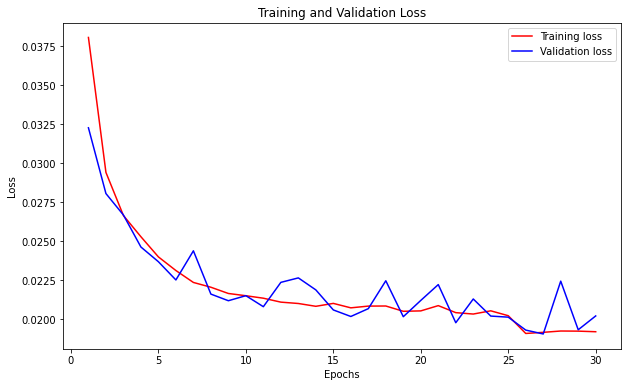

In [4]:
plot_loss_curves(train_losses, val_losses)

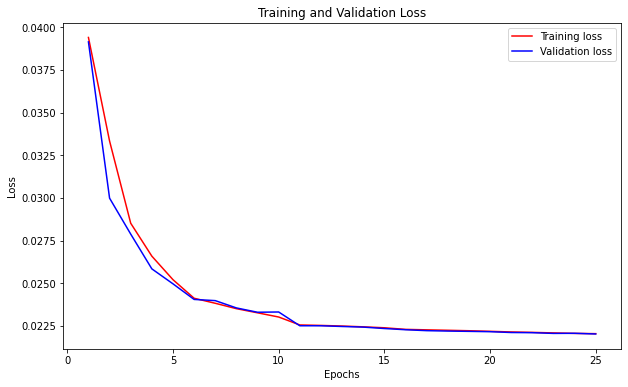

In [7]:
plot_loss_curves(train_losses, val_losses)

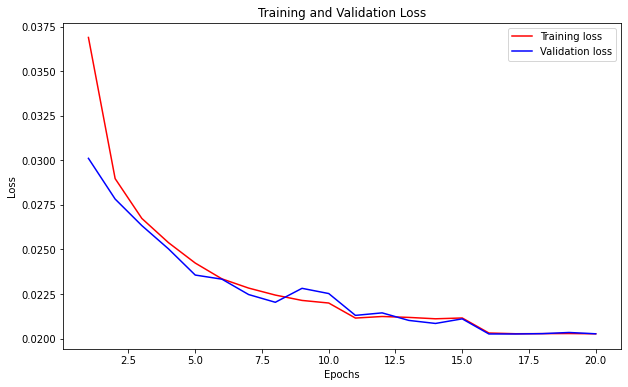

In [9]:
plot_loss_curves(train_losses, val_losses)

In [22]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import librosa.filters
import os
from torch.utils.data import DataLoader

# Define the Audio2Mel class (unchanged)
class Audio2Mel(nn.Module):
    def __init__(
        self,
        n_fft=1024,
        hop_length=256,
        win_length=1024,
        sampling_rate=22050,
        n_mel_channels=80,
        mel_fmin=0.0,
        mel_fmax=None,
        device='cuda:1'
    ):
        super().__init__()
        self.device = device
        self.win_length = win_length
        self.hop_length = hop_length
        self.n_fft = n_fft
        self.window = torch.hann_window(win_length, device=self.device).float()
        mel_basis = librosa.filters.mel(
            sr=sampling_rate,
            n_fft=n_fft,
            n_mels=n_mel_channels,
            fmin=mel_fmin,
            fmax=mel_fmax
        )
        self.mel_basis = torch.from_numpy(mel_basis).to(self.device).float()

    def forward(self, audio):
        audio = audio.to(self.device)
        p = (self.n_fft - self.hop_length) // 2
        audio_padded = F.pad(audio, (p, p), "reflect").squeeze(1)
        fft = torch.stft(
            audio_padded,
            n_fft=self.n_fft,
            hop_length=self.hop_length,
            win_length=self.win_length,
            window=self.window,
            center=False,
            return_complex=True
        )
        power = torch.abs(fft)**2
        mel_output = torch.matmul(self.mel_basis, power)
        log_mel_spec = torch.log10(torch.clamp(mel_output, min=1e-5))
        return log_mel_spec

# Define the total_loss function (unchanged)
def total_loss(wav1, wav2, sample_rate=48000):
    l1Loss = torch.nn.L1Loss(reduction='mean')
    l2Loss = torch.nn.MSELoss(reduction='mean')
    loss = torch.tensor(0.0, device=wav1.device, requires_grad=True)
    for i in range(8, 9):
        fft = Audio2Mel(win_length=2 ** i, hop_length=2 ** i // 4, n_mel_channels=64, sampling_rate=sample_rate)
        mel1 = fft(wav1)
        mel2 = fft(wav2)
        loss = loss + l1Loss(mel1, mel2) + l2Loss(mel1, mel2)
    loss = loss + l1Loss(wav1, wav2)
    return loss

# Define the function to load models and compute losses
def compute_losses(model_dir, train_dataloader, val_dataloader, test_dataloader, sample_rate=48000, device='cuda:1'):
    model_files = [f for f in os.listdir(model_dir) if f.endswith('.pth')]
    losses = {}

    for model_file in model_files:
        model_path = os.path.join(model_dir, model_file)
        checkpoint = torch.load(model_path)
        model = SimpleAutoencoder(channels=1, dimension=128, n_filters=32, n_residual_layers=1)  #model class
        model.load_state_dict(checkpoint['model_state_dict'])
        model.to(device)

        model_losses = {
            'train': [],
            'val': [],
            'test': []
        }

        for phase, dataloader in zip(['train', 'val', 'test'], [train_dataloader, val_dataloader, test_dataloader]):
            phase_loss = 0.0
            model.eval()
            with torch.no_grad():
                for batch in dataloader:
                    waveforms = batch.to(device)
                    output = model(waveforms)
                    loss = total_loss(output, waveforms, sample_rate)
                    phase_loss += loss.item()

            phase_loss /= len(dataloader)
            model_losses[phase].append(phase_loss)

        losses[model_file] = model_losses

    return losses

# Example usage
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
model_dir = "networks/L1rawL1L2mel"
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True, pin_memory=True)
val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=False, pin_memory=True)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False, pin_memory=True)

losses = compute_losses(model_dir, train_dataloader, val_dataloader, test_dataloader, sample_rate=48000, device=device)

for model_file, model_losses in losses.items():
    print(f"Model: {model_file}")
    print(f"Train Loss: {model_losses['train']}")
    print(f"Val Loss: {model_losses['val']}")
    print(f"Test Loss: {model_losses['test']}")


Model: l1_model_epoch_300.pth
Train Loss: [0.04116766734751399]
Val Loss: [0.041379922793971166]
Test Loss: [0.041595650556152816]
Model: l1_model_epoch_200.pth
Train Loss: [0.04228575556667265]
Val Loss: [0.04218389575059215]
Test Loss: [0.04277807377176742]
Model: l1_model_epoch_150.pth
Train Loss: [0.044285315975636064]
Val Loss: [0.044226943153060146]
Test Loss: [0.04480933887909536]
Model: l1_model_epoch_50.pth
Train Loss: [0.07576975632392004]
Val Loss: [0.07561267808907562]
Test Loss: [0.07612243202859409]
Model: l1_model_epoch_100.pth
Train Loss: [0.05019382948423931]
Val Loss: [0.05011132757903801]
Test Loss: [0.05082894167671465]
Model: l1_model_epoch_250.pth
Train Loss: [0.04155808202030059]
Val Loss: [0.04142207419499755]
Test Loss: [0.04211671191127333]


In [38]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import librosa.filters
import os
from torch.utils.data import DataLoader

# # Define the Audio2Mel class (unchanged)
# class Audio2Mel(nn.Module):
#     def __init__(
#         self,
#         n_fft=1024,
#         hop_length=256,
#         win_length=1024,
#         sampling_rate=22050,
#         n_mel_channels=80,
#         mel_fmin=0.0,
#         mel_fmax=None,
#         device='cuda:1'
#     ):
#         super().__init__()
#         self.device = device
#         self.win_length = win_length
#         self.hop_length = hop_length
#         self.n_fft = n_fft
#         self.window = torch.hann_window(win_length, device=self.device).float()
#         mel_basis = librosa.filters.mel(
#             sr=sampling_rate,
#             n_fft=n_fft,
#             n_mels=n_mel_channels,
#             fmin=mel_fmin,
#             fmax=mel_fmax
#         )
#         self.mel_basis = torch.from_numpy(mel_basis).to(self.device).float()

#     def forward(self, audio):
#         audio = audio.to(self.device)
#         p = (self.n_fft - self.hop_length) // 2
#         audio_padded = F.pad(audio, (p, p), "reflect").squeeze(1)
#         fft = torch.stft(
#             audio_padded,
#             n_fft=self.n_fft,
#             hop_length=self.hop_length,
#             win_length=self.win_length,
#             window=self.window,
#             center=False,
#             return_complex=True
#         )
#         power = torch.abs(fft)**2
#         mel_output = torch.matmul(self.mel_basis, power)
#         log_mel_spec = torch.log10(torch.clamp(mel_output, min=1e-5))
#         return log_mel_spec

# # Define the total_loss function (unchanged)
# def total_loss(wav1, wav2, sample_rate=48000):
#     l1Loss = torch.nn.L1Loss(reduction='mean')
#     l2Loss = torch.nn.MSELoss(reduction='mean')
#     loss = torch.tensor(0.0, device=wav1.device, requires_grad=True)
#     for i in range(8, 9):
#         fft = Audio2Mel(win_length=2 ** i, hop_length=2 ** i // 4, n_mel_channels=64, sampling_rate=sample_rate)
#         mel1 = fft(wav1)
#         mel2 = fft(wav2)
#         loss = loss + l1Loss(mel1, mel2) + l2Loss(mel1, mel2)
#     loss = loss + l1Loss(wav1, wav2)
#     return loss

total_loss = nn.L1Loss()


# Define the function to load models and compute losses
def compute_losses(model_dir, train_dataloader, val_dataloader, test_dataloader, sample_rate=48000, device='cuda:1'):
    model_files = [f for f in os.listdir(model_dir) if f.endswith('.pth')]
    losses = {}

    for model_file in model_files:
        model_path = os.path.join(model_dir, model_file)
        checkpoint = torch.load(model_path)
        model = SimpleAutoencoder(channels=1, dimension=128, n_filters=32, n_residual_layers=1)  #model class
        model.load_state_dict(checkpoint['model_state_dict'])
        model.to(device)

        model_losses = {
            'train': [],
            'val': [],
            'test': []
        }

        for phase, dataloader in zip(['train', 'val', 'test'], [train_dataloader, val_dataloader, test_dataloader]):
            phase_loss = 0.0
            model.eval()
            with torch.no_grad():
                for batch in dataloader:
                    waveforms = batch.to(device)
                    output = model(waveforms)
                    loss = total_loss(output, waveforms)
                    phase_loss += loss.item()

            phase_loss /= len(dataloader)
            model_losses[phase].append(phase_loss)

        losses[model_file] = model_losses

    return losses

# Example usage
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
model_dir = "networks/L1rawL1L2mel"
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True, pin_memory=True)
val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=False, pin_memory=True)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False, pin_memory=True)

losses = compute_losses(model_dir, train_dataloader, val_dataloader, test_dataloader, sample_rate=48000, device=device)

for model_file, model_losses in losses.items():
    print(f"Model: {model_file}")
    print(f"Train Loss: {model_losses['train']}")
    print(f"Val Loss: {model_losses['val']}")
    print(f"Test Loss: {model_losses['test']}")


Model: l1_model_epoch_300.pth
Train Loss: [0.004200195669876914]
Val Loss: [0.004085853977206473]
Test Loss: [0.004245436233659722]
Model: l1_model_epoch_200.pth
Train Loss: [0.004194796649309734]
Val Loss: [0.004155439421689759]
Test Loss: [0.004171223794301487]
Model: l1_model_epoch_150.pth
Train Loss: [0.004255416913203404]
Val Loss: [0.00419098596386094]
Test Loss: [0.004263078152801688]
Model: l1_model_epoch_50.pth
Train Loss: [0.005715704719608505]
Val Loss: [0.0056708457931462265]
Test Loss: [0.005678726379338601]
Model: l1_model_epoch_100.pth
Train Loss: [0.004468176385644311]
Val Loss: [0.004376723185285098]
Test Loss: [0.004468425786224742]
Model: l1_model_epoch_250.pth
Train Loss: [0.004204676020890474]
Val Loss: [0.004136368376849633]
Test Loss: [0.004203998024435076]


In [23]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import librosa.filters
import os
from torch.utils.data import DataLoader

# Define the Audio2Mel class (unchanged)
class Audio2Mel(nn.Module):
    def __init__(
        self,
        n_fft=1024,
        hop_length=256,
        win_length=1024,
        sampling_rate=22050,
        n_mel_channels=80,
        mel_fmin=0.0,
        mel_fmax=None,
        device='cuda:1'
    ):
        super().__init__()
        self.device = device
        self.win_length = win_length
        self.hop_length = hop_length
        self.n_fft = n_fft
        self.window = torch.hann_window(win_length, device=self.device).float()
        mel_basis = librosa.filters.mel(
            sr=sampling_rate,
            n_fft=n_fft,
            n_mels=n_mel_channels,
            fmin=mel_fmin,
            fmax=mel_fmax
        )
        self.mel_basis = torch.from_numpy(mel_basis).to(self.device).float()

    def forward(self, audio):
        audio = audio.to(self.device)
        p = (self.n_fft - self.hop_length) // 2
        audio_padded = F.pad(audio, (p, p), "reflect").squeeze(1)
        fft = torch.stft(
            audio_padded,
            n_fft=self.n_fft,
            hop_length=self.hop_length,
            win_length=self.win_length,
            window=self.window,
            center=False,
            return_complex=True
        )
        power = torch.abs(fft)**2
        mel_output = torch.matmul(self.mel_basis, power)
        log_mel_spec = torch.log10(torch.clamp(mel_output, min=1e-5))
        return log_mel_spec

# Define the total_loss function to return individual losses
def total_loss(wav1, wav2, sample_rate=48000):
    l1Loss = torch.nn.L1Loss(reduction='mean')
    l2Loss = torch.nn.MSELoss(reduction='mean')
    
    l1_raw_audio_loss = l1Loss(wav1, wav2)
    l1_mel_loss = 0.0
    l2_mel_loss = 0.0

    for i in range(8, 9):
        fft = Audio2Mel(win_length=2 ** i, hop_length=2 ** i // 4, n_mel_channels=64, sampling_rate=sample_rate)
        mel1 = fft(wav1)
        mel2 = fft(wav2)
        l1_mel_loss += l1Loss(mel1, mel2)
        l2_mel_loss += l2Loss(mel1, mel2)

    total_loss_value = l1_raw_audio_loss + l1_mel_loss + l2_mel_loss

    return l1_raw_audio_loss, l1_mel_loss, l2_mel_loss, total_loss_value

# Define the function to load models and compute losses
def compute_losses(model_dir, train_dataloader, val_dataloader, test_dataloader, sample_rate=48000, device='cuda:1'):
    model_files = [f for f in os.listdir(model_dir) if f.endswith('.pth')]
    losses = {}

    for model_file in model_files:
        model_path = os.path.join(model_dir, model_file)
        checkpoint = torch.load(model_path)
        
        if 'model_state_dict' not in checkpoint:
            print(f"Skipping file {model_file} as it doesn't contain a model state dictionary.")
            continue

        # Instantiate the model and load its state_dict
        model =  SimpleAutoencoder(channels=1, dimension=128, n_filters=32, n_residual_layers=1)  # Replace with your model class
        model.load_state_dict(checkpoint['model_state_dict'])
        model.to(device)

        model_losses = {
            'train': {'l1_raw_audio_loss': 0.0, 'l1_mel_loss': 0.0, 'l2_mel_loss': 0.0, 'total_loss': 0.0},
            'val': {'l1_raw_audio_loss': 0.0, 'l1_mel_loss': 0.0, 'l2_mel_loss': 0.0, 'total_loss': 0.0},
            'test': {'l1_raw_audio_loss': 0.0, 'l1_mel_loss': 0.0, 'l2_mel_loss': 0.0, 'total_loss': 0.0}
        }

        for phase, dataloader in zip(['train', 'val', 'test'], [train_dataloader, val_dataloader, test_dataloader]):
            l1_raw_audio_loss_sum = 0.0
            l1_mel_loss_sum = 0.0
            l2_mel_loss_sum = 0.0
            total_loss_sum = 0.0

            model.eval()
            with torch.no_grad():
                for batch in dataloader:
                    waveforms = batch.to(device)
                    output = model(waveforms)
                    l1_raw_audio_loss, l1_mel_loss, l2_mel_loss, total_loss_value = total_loss(output, waveforms, sample_rate)
                    
                    l1_raw_audio_loss_sum += l1_raw_audio_loss.item()
                    l1_mel_loss_sum += l1_mel_loss.item()
                    l2_mel_loss_sum += l2_mel_loss.item()
                    total_loss_sum += total_loss_value.item()

            model_losses[phase]['l1_raw_audio_loss'] = l1_raw_audio_loss_sum / len(dataloader)
            model_losses[phase]['l1_mel_loss'] = l1_mel_loss_sum / len(dataloader)
            model_losses[phase]['l2_mel_loss'] = l2_mel_loss_sum / len(dataloader)
            model_losses[phase]['total_loss'] = total_loss_sum / len(dataloader)

        losses[model_file] = model_losses

    return losses

# Example usage
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
model_dir = "networks/L1rawL1L2mel"
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True, pin_memory=True)
val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=False, pin_memory=True)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False, pin_memory=True)

losses = compute_losses(model_dir, train_dataloader, val_dataloader, test_dataloader, sample_rate=48000, device=device)

for model_file, model_losses in losses.items():
    print(f"Model: {model_file}")
    print(f"Train Losses: {model_losses['train']}")
    print(f"Val Losses: {model_losses['val']}")
    print(f"Test Losses: {model_losses['test']}")


Model: l1_model_epoch_300.pth
Train Losses: {'l1_raw_audio_loss': 0.004210587796576678, 'l1_mel_loss': 0.028699619427858713, 'l2_mel_loss': 0.008372541691293705, 'total_loss': 0.04128274898195338}
Val Losses: {'l1_raw_audio_loss': 0.004106520283837906, 'l1_mel_loss': 0.028618788346648216, 'l2_mel_loss': 0.00846948543848056, 'total_loss': 0.041194794337368675}
Test Losses: {'l1_raw_audio_loss': 0.004175800568590017, 'l1_mel_loss': 0.028914756435033395, 'l2_mel_loss': 0.008577460270017793, 'total_loss': 0.041668017382082874}
Model: l1_model_epoch_200.pth
Train Losses: {'l1_raw_audio_loss': 0.004247396830943396, 'l1_mel_loss': 0.029521426743643726, 'l2_mel_loss': 0.008596579915102192, 'total_loss': 0.04236540362283498}
Val Losses: {'l1_raw_audio_loss': 0.004085734580358904, 'l1_mel_loss': 0.02928033675481048, 'l2_mel_loss': 0.008632739132735878, 'total_loss': 0.04199881044526895}
Test Losses: {'l1_raw_audio_loss': 0.004235055734569284, 'l1_mel_loss': 0.029875062431578767, 'l2_mel_loss': 0

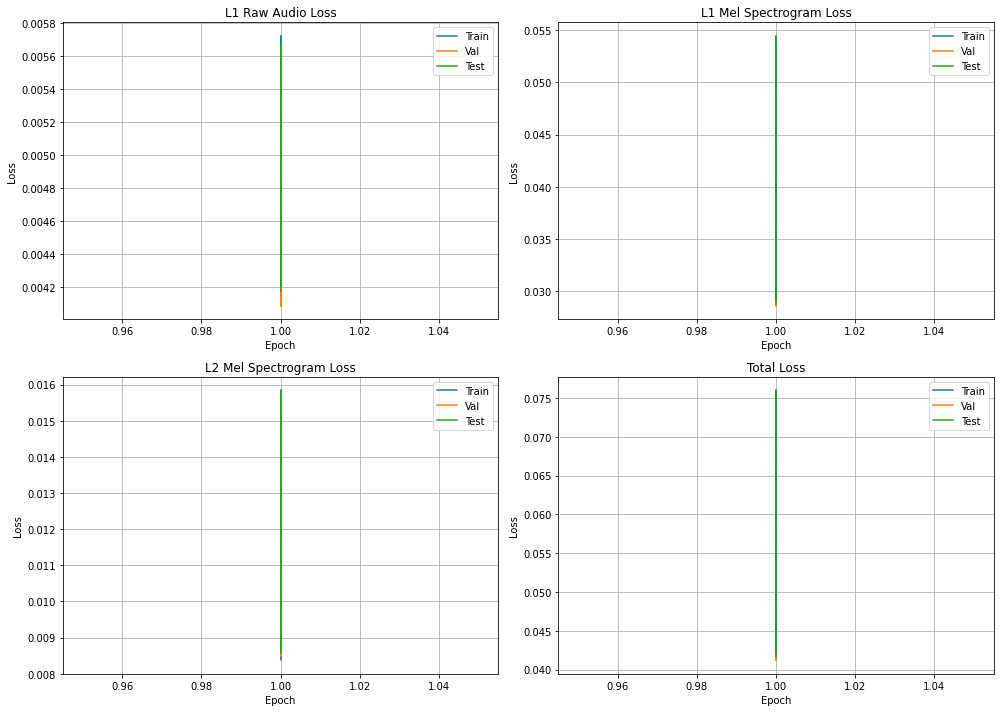

In [25]:
import matplotlib.pyplot as plt
import re

# Sample losses dictionary (this should be replaced with the actual computed losses)
# losses = {
#     'l1_model_epoch_300.pth': {
#         'train': {'l1_raw_audio_loss': 0.004210587796576678, 'l1_mel_loss': 0.028699619427858713, 'l2_mel_loss': 0.008372541691293705, 'total_loss': 0.04128274898195338},
#         'val': {'l1_raw_audio_loss': 0.004106520283837906, 'l1_mel_loss': 0.028618788346648216, 'l2_mel_loss': 0.00846948543848056, 'total_loss': 0.041194794337368675},
#         'test': {'l1_raw_audio_loss': 0.004175800568590017, 'l1_mel_loss': 0.028914756435033395, 'l2_mel_loss': 0.008577460270017793, 'total_loss': 0.041668017382082874},
#     },
#     'l1_model_epoch_200.pth': {
#         'train': {'l1_raw_audio_loss': 0.004247396830943396, 'l1_mel_loss': 0.029521426743643726, 'l2_mel_loss': 0.008596579915102192, 'total_loss': 0.04236540362283498},
#         'val': {'l1_raw_audio_loss': 0.004085734580358904, 'l1_mel_loss': 0.02928033675481048, 'l2_mel_loss': 0.008632739132735878, 'total_loss': 0.04199881044526895},
#         'test': {'l1_raw_audio_loss': 0.004235055734569284, 'l1_mel_loss': 0.029875062431578767, 'l2_mel_loss': 0.008863536698411997, 'total_loss': 0.04297365472741323},
#     },
#     'l1_model_epoch_150.pth': {
#         'train': {'l1_raw_audio_loss': 0.0042561130370933585, 'l1_mel_loss': 0.031216420110560462, 'l2_mel_loss': 0.008860448672307912, 'total_loss': 0.044332981912675734},
#         'val': {'l1_raw_audio_loss': 0.004139210155699402, 'l1_mel_loss': 0.03111687548355096, 'l2_mel_loss': 0.008925839676521719, 'total_loss': 0.04418192545158996},
#         'test': {'l1_raw_audio_loss': 0.0042605977186499396, 'l1_mel_loss': 0.03163038724905824, 'l2_mel_loss': 0.00914043262090585, 'total_loss': 0.04503141741638314},
#     },
#     'l1_model_epoch_50.pth': {
#         'train': {'l1_raw_audio_loss': 0.005720226315803781, 'l1_mel_loss': 0.05435399355333365, 'l2_mel_loss': 0.015683321176308714, 'total_loss': 0.07575754089626724},
#         'val': {'l1_raw_audio_loss': 0.0056140107529548304, 'l1_mel_loss': 0.054226390500035554, 'l2_mel_loss': 0.015753332499621645, 'total_loss': 0.07559373426354593},
#         'test': {'l1_raw_audio_loss': 0.00568513997052222, 'l1_mel_loss': 0.05443879324075294, 'l2_mel_loss': 0.01583748675678691, 'total_loss': 0.07596141947050618},
#     },
#     'l1_model_epoch_100.pth': {
#         'train': {'l1_raw_audio_loss': 0.0044629953349912595, 'l1_mel_loss': 0.0357631883377622, 'l2_mel_loss': 0.010140952230347488, 'total_loss': 0.0503671358556983},
#         'val': {'l1_raw_audio_loss': 0.004379182737061961, 'l1_mel_loss': 0.03567039268091321, 'l2_mel_loss': 0.010224435336163474, 'total_loss': 0.05027401069593099},
#         'test': {'l1_raw_audio_loss': 0.004429624910300521, 'l1_mel_loss': 0.035941015469701326, 'l2_mel_loss': 0.010323034650454782, 'total_loss': 0.05069367505916177},
#     },
#     'l1_model_epoch_250.pth': {
#         'train': {'l1_raw_audio_loss': 0.00421897387954624, 'l1_mel_loss': 0.028963907248156513, 'l2_mel_loss': 0.00844088007004452, 'total_loss': 0.04162376124166443},
#         'val': {'l1_raw_audio_loss': 0.004089129344922387, 'l1_mel_loss': 0.02881559225109716, 'l2_mel_loss': 0.008511269587971684, 'total_loss': 0.04141599115812116},
#         'test': {'l1_raw_audio_loss': 0.004207144711447293, 'l1_mel_loss': 0.029302942477268716, 'l2_mel_loss': 0.008681850424929433, 'total_loss': 0.04219193741270941},
#     },
# }

# Extract epochs and losses
epochs = []
train_losses = {'l1_raw_audio_loss': [], 'l1_mel_loss': [], 'l2_mel_loss': [], 'total_loss': []}
val_losses = {'l1_raw_audio_loss': [], 'l1_mel_loss': [], 'l2_mel_loss': [], 'total_loss': []}
test_losses = {'l1_raw_audio_loss': [], 'l1_mel_loss': [], 'l2_mel_loss': [], 'total_loss': []}

for model_file, model_losses in losses.items():
    epoch = int(re.search(r'\d+', model_file).group())
    epochs.append(epoch)
    
    for loss_type in train_losses.keys():
        train_losses[loss_type].append(model_losses['train'][loss_type])
        val_losses[loss_type].append(model_losses['val'][loss_type])
        test_losses[loss_type].append(model_losses['test'][loss_type])

# Sort by epochs
sorted_indices = sorted(range(len(epochs)), key=lambda k: epochs[k])
epochs = [epochs[i] for i in sorted_indices]

for loss_type in train_losses.keys():
    train_losses[loss_type] = [train_losses[loss_type][i] for i in sorted_indices]
    val_losses[loss_type] = [val_losses[loss_type][i] for i in sorted_indices]
    test_losses[loss_type] = [test_losses[loss_type][i] for i in sorted_indices]

# Plotting
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

loss_types = ['l1_raw_audio_loss', 'l1_mel_loss', 'l2_mel_loss', 'total_loss']
titles = ['L1 Raw Audio Loss', 'L1 Mel Spectrogram Loss', 'L2 Mel Spectrogram Loss', 'Total Loss']

for i, ax in enumerate(axes.flat):
    loss_type = loss_types[i]
    ax.plot(epochs, train_losses[loss_type], label='Train')
    ax.plot(epochs, val_losses[loss_type], label='Val')
    ax.plot(epochs, test_losses[loss_type], label='Test')
    ax.set_title(titles[i])
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    ax.legend()
    ax.grid(True)

plt.tight_layout()
plt.show()


In [28]:
epochs

[1, 1, 1, 1, 1, 1]

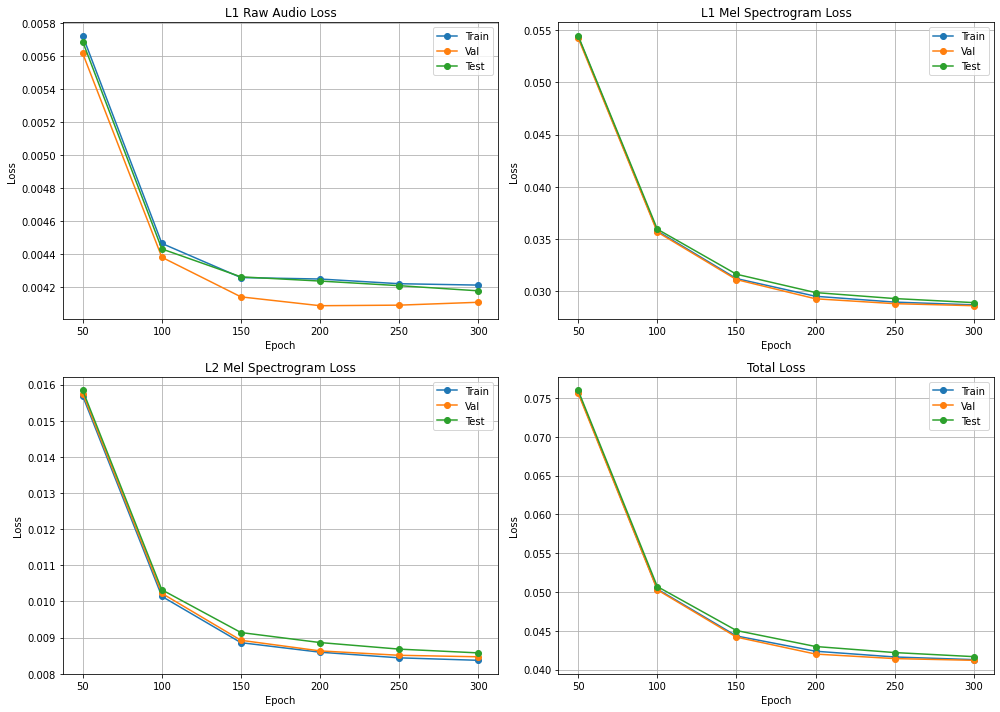

In [29]:
epochs = []
train_losses = {'l1_raw_audio_loss': [], 'l1_mel_loss': [], 'l2_mel_loss': [], 'total_loss': []}
val_losses = {'l1_raw_audio_loss': [], 'l1_mel_loss': [], 'l2_mel_loss': [], 'total_loss': []}
test_losses = {'l1_raw_audio_loss': [], 'l1_mel_loss': [], 'l2_mel_loss': [], 'total_loss': []}

for model_file, model_losses in losses.items():
    # Use regular expression to extract the epoch number from the filename
    match = re.search(r'epoch_(\d+)', model_file)
    if match:
        epoch = int(match.group(1))
        epochs.append(epoch)

        for loss_type in train_losses.keys():
            train_losses[loss_type].append(model_losses['train'][loss_type])
            val_losses[loss_type].append(model_losses['val'][loss_type])
            test_losses[loss_type].append(model_losses['test'][loss_type])

# Sort by epochs
sorted_indices = sorted(range(len(epochs)), key=lambda k: epochs[k])
epochs = [epochs[i] for i in sorted_indices]

for loss_type in train_losses.keys():
    train_losses[loss_type] = [train_losses[loss_type][i] for i in sorted_indices]
    val_losses[loss_type] = [val_losses[loss_type][i] for i in sorted_indices]
    test_losses[loss_type] = [test_losses[loss_type][i] for i in sorted_indices]

# Plotting
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

loss_types = ['l1_raw_audio_loss', 'l1_mel_loss', 'l2_mel_loss', 'total_loss']
titles = ['L1 Raw Audio Loss', 'L1 Mel Spectrogram Loss', 'L2 Mel Spectrogram Loss', 'Total Loss']

for i, ax in enumerate(axes.flat):
    loss_type = loss_types[i]
    ax.plot(epochs, train_losses[loss_type], label='Train', marker='o')
    ax.plot(epochs, val_losses[loss_type], label='Val', marker='o')
    ax.plot(epochs, test_losses[loss_type], label='Test', marker='o')
    ax.set_title(titles[i])
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    ax.legend()
    ax.grid(True)

plt.tight_layout()
plt.show()

In [43]:
l1=torch.load("networks/L1rawL1L2mel/losses/l1_model_losses.pth")['train_losses']

In [44]:
l2=torch.load("networks/L1rawL1L2mel/losses/l1_model_losses.pth")['val_losses']

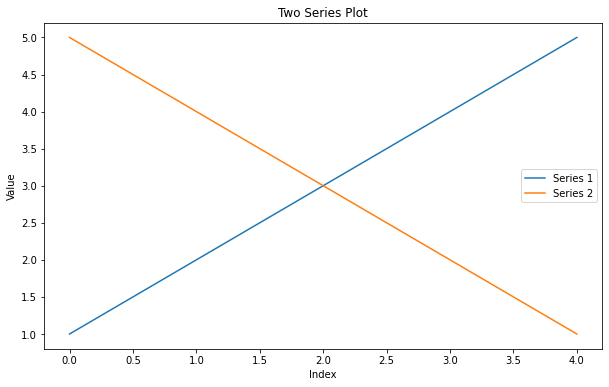

In [45]:
import matplotlib.pyplot as plt

def plot_series(series1, series2):
    """
    Plots two series.
    
    Args:
    - series1: List or array-like object containing the first series data points.
    - series2: List or array-like object containing the second series data points.
    
    Returns:
    - None
    """
    # Ensure series have the same length
    if len(series1) != len(series2):
        raise ValueError("Series must have the same length.")
    
    # Plotting
    plt.figure(figsize=(10, 6))
    plt.plot(series1, label='Series 1')
    plt.plot(series2, label='Series 2')
    
    # Adding labels and legend
    plt.xlabel('Index')
    plt.ylabel('Value')
    plt.title('Two Series Plot')
    plt.legend()
    
    # Display plot
    plt.show()

# Example usage:
series1 = [1, 2, 3, 4, 5]
series2 = [5, 4, 3, 2, 1]
plot_series(series1, series2)


In [12]:
mdl = model.to('cpu')

In [64]:
mdl.load_state_dict(torch.load('l1_model_epoch_300.pth')['model_state_dict'])


<All keys matched successfully>

In [51]:
mdl.load_state_dict(torch.load('networks/L1raw/l1raw_model_epoch_300.pth')['model_state_dict'])


<All keys matched successfully>

# Audio Test

In [10]:
import IPython

In [11]:
import matplotlib.pyplot as plt
import numpy as np

def plot_audio_signals(original_signal, reconstructed_signal, sample_rate):
    """
    Plot the original and reconstructed audio signals vertically.
    
    Args:
        original_signal (np.ndarray): The original audio signal.
        reconstructed_signal (np.ndarray): The reconstructed audio signal.
        sample_rate (int): The sample rate of the audio signals.
        
    Returns:
        None
    """
    min_length = min(len(original_signal), len(reconstructed_signal))
    time = np.arange(min_length) / sample_rate
    
    fig, axs = plt.subplots(2, 1, figsize=(10, 4), sharex=True)
    
    axs[0].plot(time, original_signal[:min_length], color='b', label='Original Signal')
    axs[0].set_title('Original Audio Signal')
    axs[0].set_ylabel('Amplitude')
    axs[0].legend()
    axs[0].grid(True)
    
    axs[1].plot(time, reconstructed_signal[:min_length], color='r', alpha=0.7, label='Reconstructed Signal')
    axs[1].set_title('Reconstructed Audio Signal')
    axs[1].set_xlabel('Time (s)')
    axs[1].set_ylabel('Amplitude')
    axs[1].legend()
    axs[1].grid(True)
    
    plt.tight_layout()
    plt.show()

# Test Audio

In [65]:
import soundfile as sf


a = rfd("test")
a1 = sf.read(a)[0].astype('float32')
c = torch.tensor(sf.read(a)[0].astype('float32'))
d = c.unsqueeze(0).unsqueeze(0)
d1 = mdl.decoder(mdl.encoder(d)).flatten().detach().numpy()

In [17]:
import soundfile as sf


a = rfd(ddr+"test24khz")
a1 = sf.read(a)[0].astype('float32')
c = torch.tensor(sf.read(a)[0].astype('float32'))
d = c.unsqueeze(0).unsqueeze(0)
#d1 = mdl.decoder(mdl.encoder(d)).flatten().detach().numpy()
d1 = mdl(d)[0].flatten().detach().numpy()

In [13]:
import soundfile as sf


a = rfd(ddr+"train24khz")
a1 = sf.read(a)[0].astype('float32')
c = torch.tensor(sf.read(a)[0].astype('float32'))
d = c.unsqueeze(0).unsqueeze(0)
#d1 = mdl.decoder(mdl.encoder(d)).flatten().detach().numpy()
d1 = mdl(d)[0].flatten().detach().numpy()

In [15]:
IPython.display.Audio(a1,rate=24000)

In [17]:
IPython.display.Audio(d1,rate=24000)

In [30]:
IPython.display.Audio(d1,rate=48000)

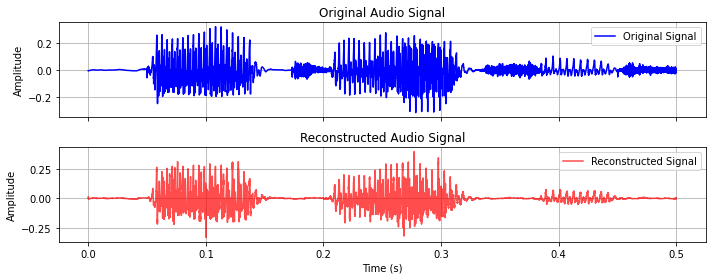

In [14]:
plot_audio_signals(a1,d1,48000)

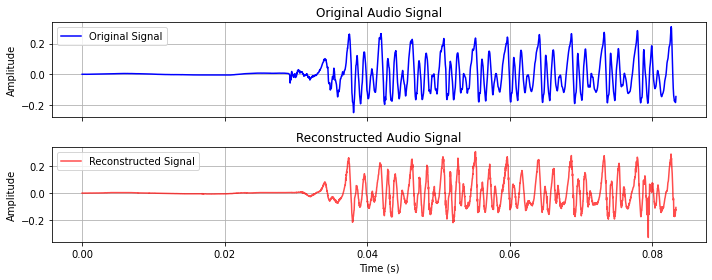

In [15]:
plot_audio_signals(a1[1000:5000],d1[1000:5000],48000)

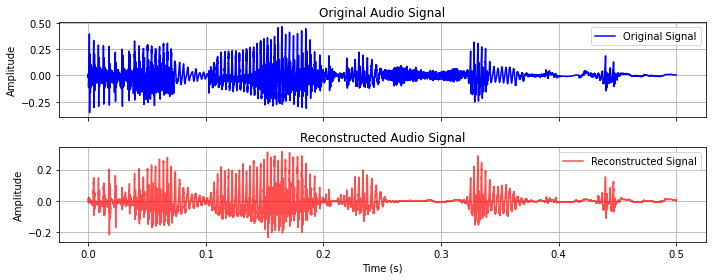

In [18]:
plot_audio_signals(a1,d1,48000)

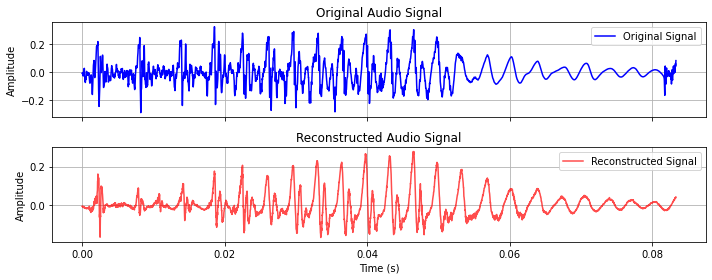

In [19]:
plot_audio_signals(a1[1000:5000],d1[1000:5000],48000)

# Unknown Speaker

In [71]:
import soundfile as sf


a = rfd(rfd("wav48/4"))
a1 = sf.read(a)[0].astype('float32')
c = torch.tensor(sf.read(a)[0].astype('float32'))
d = c.unsqueeze(0).unsqueeze(0)
d1 = mdl.decoder(mdl.encoder(d)).flatten().detach().numpy()

In [72]:
IPython.display.Audio(a1,rate=48000)

In [73]:
IPython.display.Audio(d1,rate=48000)

In [102]:
IPython.display.Audio(d1,rate=48000)

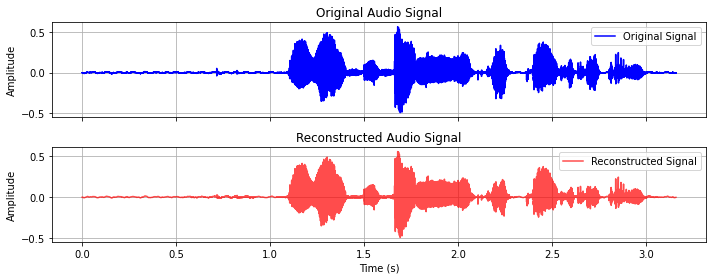

In [32]:
plot_audio_signals(a1,d1,48000)

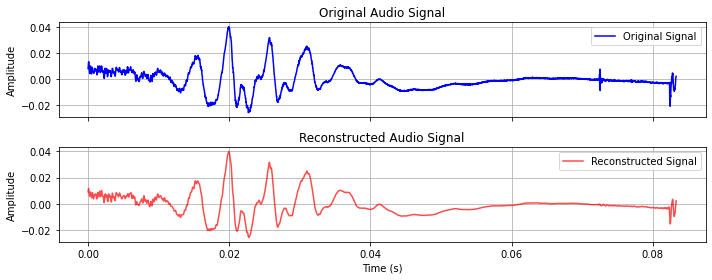

In [40]:
plot_audio_signals(a1[21*48000//10+1000:21*48000//10+5000],d1[21*48000//10+1000:21*48000//10+5000],48000)

In [19]:
model=model.to('cpu');

# Train Audio

In [32]:
import soundfile as sf


a = rfd("train")
a1 = sf.read(a)[0].astype('float32')
c = torch.tensor(sf.read(a)[0].astype('float32'))
d = c.unsqueeze(0).unsqueeze(0)
d1 = model.decoder(model.encoder(d)).flatten().detach().numpy()

In [33]:
IPython.display.Audio(a1,rate=48000)

In [34]:
IPython.display.Audio(d1,rate=48000)

In [26]:
IPython.display.Audio(d1,rate=48000)

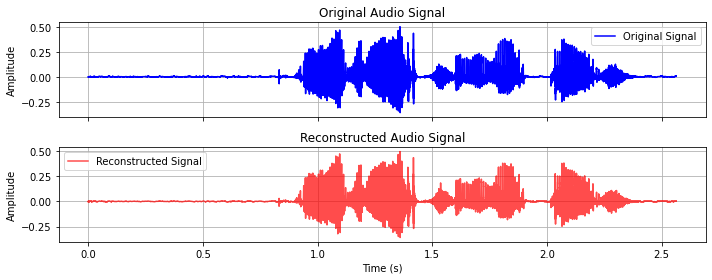

In [27]:
plot_audio_signals(a1,d1,48000)

In [17]:
import matplotlib.pyplot as plt
import numpy as np

def plot_audio_signals(original_signal, reconstructed_signal, sample_rate):
    """
    Plot the original and reconstructed audio signals vertically.
    
    Args:
        original_signal (np.ndarray): The original audio signal.
        reconstructed_signal (np.ndarray): The reconstructed audio signal.
        sample_rate (int): The sample rate of the audio signals.
        
    Returns:
        None
    """
    min_length = min(len(original_signal), len(reconstructed_signal))
    time = np.arange(min_length) / sample_rate
    
    fig, axs = plt.subplots(2, 1, figsize=(10, 4), sharex=True)
    
    axs[0].plot(time, original_signal[:min_length], color='b', label='Original Signal')
    axs[0].set_title('Original Audio Signal')
    axs[0].set_ylabel('Amplitude')
    axs[0].legend()
    axs[0].grid(True)
    
    axs[1].plot(time, reconstructed_signal[:min_length], color='r', alpha=0.7, label='Reconstructed Signal')
    axs[1].set_title('Reconstructed Audio Signal')
    axs[1].set_xlabel('Time (s)')
    axs[1].set_ylabel('Amplitude')
    axs[1].legend()
    axs[1].grid(True)
    
    plt.tight_layout()
    plt.show()

In [6]:
import os
import torchaudio
import torch

def trim_silence(waveform, sample_rate, silence_threshold=0.001, min_silence_duration=0.1):
    """
    Trim silence from the start and end of a waveform.
    
    Args:
    - waveform: Tensor, the audio waveform to be processed.
    - sample_rate: int, the sample rate of the audio.
    - silence_threshold: float, threshold to consider a part of the waveform as silence.
    - min_silence_duration: float, minimum duration of silence to be trimmed in seconds.
    
    Returns:
    - Tensor: The trimmed waveform.
    """
    # Convert to mono if it's stereo
    if waveform.shape[0] > 1:
        waveform = torch.mean(waveform, dim=0, keepdim=True)
    
    # Calculate the energy of the waveform
    energy = torch.square(waveform).mean(dim=0)
    
    # Find indices where the energy is above a certain threshold
    mask = energy > silence_threshold
    
    # Convert to indices and find continuous segments
    indices = torch.where(mask)[0]
    if len(indices) == 0:
        # All silent, return the waveform as is (or could handle differently)
        return waveform
    else:
        # Get start and end indices of non-silent parts
        start = indices[0].item()
        end = indices[-1].item() + 1
        
        # Convert start and end to samples, accounting for minimum duration of silence
        min_silence_samples = int(min_silence_duration * sample_rate)
        start = max(0, start - min_silence_samples)
        end = min(waveform.shape[1], end + min_silence_samples)
        
        # Trim the waveform
        return waveform[:, start:end]

def process_directory(root_dir, target_dir):
    # Ensure target directory exists
    os.makedirs(target_dir, exist_ok=True)
    
    # Walk through all files in root_dir and process them
    for dirpath, _, filenames in os.walk(root_dir):
        for filename in filenames:
            if filename.endswith('.wav'):
                file_path = os.path.join(dirpath, filename)
                target_path = os.path.join(target_dir, filename)
                #print(f"Processing {file_path}...")                             """ Optional"""
                
                # Load the waveform
                waveform, sample_rate = torchaudio.load(file_path)
                
                # Trim silence
                trimmed_waveform = trim_silence(waveform, sample_rate)
                
                # Save the trimmed waveform
                torchaudio.save(target_path, trimmed_waveform, sample_rate)

In [7]:
# Example usage:
root_dir = 'val'
target_dir = 'val3'
#process_directory(root_dir, target_dir)

In [ ]:
#process_directory(root_dir, target_dir)

In [8]:
# import time


# start_time = time.time()
# process_directory(root_dir, target_dir)
# end_time = time.time()

# execution_time = end_time - start_time
# print("Execution time:", execution_time, "seconds")


Execution time: 18.063681602478027 seconds


In [50]:
def trim_silence(waveform, threshold=0.01):
    energy = waveform.pow(2).sum(0) / waveform.shape[-1]
    mask = energy > threshold
    nonzero_indices = torch.nonzero(mask)
    if len(nonzero_indices) == 0:
        return waveform
    start_idx = nonzero_indices[0]
    end_idx = nonzero_indices[-1] + 1
    return waveform[:, start_idx:end_idx]

In [121]:
def plot_waveform(waveform, sample_rate=48000):
    duration = waveform.shape[1] / sample_rate
    time = np.linspace(0, duration, waveform.shape[1])
    plt.figure(figsize=(10, 4))
    plt.plot(time, waveform.t().numpy())
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.title('Waveform')
    plt.show()

In [5]:
import matplotlib.pyplot as plt
import numpy as np

def plot_waveform(waveform, sample_rate=48000):
    if waveform.dim() == 2:
        waveform = waveform.mean(dim=0)  # If stereo, take the mean
    duration = waveform.shape[0] / sample_rate
    time = np.linspace(0, duration, waveform.shape[0])
    plt.figure(figsize=(10, 4))
    plt.plot(time, waveform.numpy())
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.title('Waveform')
    plt.show()


In [52]:
import os
import torchaudio
import torch

def create_one_second_chunks(input_dir, output_dir, overlap_ratio=0.1):
    """
    Creates 1-second chunks from all .wav files in the input directory.
    The chunks are saved in the output directory with the naming convention "file_1.wav", "file_2.wav", etc.
    The chunks have an overlap ratio of 10% by default.
    
    Parameters:
    input_dir (str): Directory containing input .wav files.
    output_dir (str): Directory to save the output chunks.
    overlap_ratio (float): Overlap ratio for the chunks (default is 10%).
    """
    for filename in os.listdir(input_dir):
        if filename.endswith('.wav'):
            audio_path = os.path.join(input_dir, filename)
            audio, sample_rate = torchaudio.load(audio_path)
            samples_per_second = sample_rate
            chunk_length = samples_per_second  # 1 second chunk length
            overlap_samples = int(overlap_ratio * chunk_length)  # 10% overlap

            base_name, _ = os.path.splitext(filename)
            output_files = []
            
            for i in range(0, audio.size(-1), chunk_length - overlap_samples):
                start = i
                end = i + chunk_length
                if end > audio.size(-1):
                    # Adjust the last chunk to ensure it ends at the end of the file
                    start = max(0, audio.size(-1) - chunk_length)
                    end = audio.size(-1)
                chunk = audio[:, start:end]

                # Ensure chunk is exactly 1 second long
                if chunk.size(-1) < chunk_length:
                    chunk = torch.nn.functional.pad(chunk, (0, chunk_length - chunk.size(-1)))

                output_filename = f"{base_name}_{len(output_files) + 1}.wav"
                output_path = os.path.join(output_dir, output_filename)
                torchaudio.save(output_path, chunk, sample_rate)
                output_files.append(output_filename)
            
            #print(f"Created {len(output_files)} chunks from {filename}")

In [51]:
# Example usage:
input_directory = 'input_wav_files'
output_directory = 'output_chunks'
os.makedirs(output_directory, exist_ok=True)
create_one_second_chunks(input_directory, output_directory)

FileNotFoundError: [Errno 2] No such file or directory: 'input_wav_files'

In [37]:
import os
import torchaudio
import torch

def create_one_second_chunks(input_dir, output_dir, overlap_ratio=0.1):
    """
    Creates 1-second chunks from all .wav files in the input directory.
    The chunks are saved in the output directory with the naming convention "file_1.wav", "file_2.wav", etc.
    The chunks have an overlap ratio of 10% by default.
    """
    for filename in os.listdir(input_dir):
        if filename.endswith('.wav'):
            audio_path = os.path.join(input_dir, filename)
            audio, sample_rate = torchaudio.load(audio_path)
            samples_per_second = sample_rate
            chunk_length = samples_per_second
            overlap_samples = int(overlap_ratio * chunk_length)
            
            base_name, _ = os.path.splitext(filename)
            output_files = []
            
            for i in range(0, audio.size(-1), chunk_length - overlap_samples):
                start = i
                end = i + chunk_length
                if end > audio.size(-1):
                    start = audio.size(-1) - chunk_length
                    end = audio.size(-1)
                chunk = audio[:, start:end]
                
                output_filename = f"{base_name}_{len(output_files) + 1}.wav"
                output_path = os.path.join(output_dir, output_filename)
                torchaudio.save(output_path, chunk, sample_rate)
                output_files.append(output_filename)
            
            #print(f"Created {len(output_files)} chunks from {filename}")

In [53]:

input_dir = "test1"
output_dir = "/home/archisman/SSDdir/AB_datasets/Encodec/test2"
os.makedirs(output_dir, exist_ok=True)
create_one_second_chunks(input_dir, output_dir)

In [54]:

input_dir = "val1"
output_dir = "/home/archisman/SSDdir/AB_datasets/Encodec/val2"
os.makedirs(output_dir, exist_ok=True)
create_one_second_chunks(input_dir, output_dir)

In [55]:

input_dir = "train1"
output_dir = "/home/archisman/SSDdir/AB_datasets/Encodec/train2"
os.makedirs(output_dir, exist_ok=True)
create_one_second_chunks(input_dir, output_dir)

In [8]:
import os
import torchaudio

def convert_wav_to_24khz_torchaudio(input_dir, output_dir):
    os.makedirs(output_dir, exist_ok=True)
    for filename in os.listdir(input_dir):
        if filename.endswith('.wav'):
            input_path = os.path.join(input_dir, filename)
            output_path = os.path.join(output_dir, filename)
            waveform, sample_rate = torchaudio.load(input_path)
            if sample_rate != 24000:
                resampler = torchaudio.transforms.Resample(orig_freq=sample_rate, new_freq=24000)
                resampled_waveform = resampler(waveform)
                torchaudio.save(output_path, resampled_waveform, sample_rate=24000)

In [9]:
# Example usage:
input_directory = "/home/archisman/SSDdir/AB_datasets/Encodec/train2"
output_directory = "/home/archisman/SSDdir/AB_datasets/Encodec/train24khz"
convert_wav_to_24khz_torchaudio(input_directory, output_directory)

In [10]:
# Example usage:
input_directory = "/home/archisman/SSDdir/AB_datasets/Encodec/test2"
output_directory = "/home/archisman/SSDdir/AB_datasets/Encodec/test24khz"
convert_wav_to_24khz_torchaudio(input_directory, output_directory)

In [11]:
# Example usage:
input_directory = "/home/archisman/SSDdir/AB_datasets/Encodec/val2"
output_directory = "/home/archisman/SSDdir/AB_datasets/Encodec/val24khz"
convert_wav_to_24khz_torchaudio(input_directory, output_directory)